In [1]:
%matplotlib inline

import gc
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import scipy as sp
import numpy as np

plt.style.use('seaborn-whitegrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index().drop('level_0', axis=1)
    merged = pd.merge(
        df, source_data[group_columns],
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


**H2** Varying effects models are useful for modeling time series, as well as spatial clustering. In a time series, the observations cluster by entities that have continuity through time, such as individuals. Since observations within individuals are likely highly correlated, the multilevel structure can help quite a lot. You’ll use the data in `Oxboys`, which is 234 height measurements on 26 boys from an Oxford Boys Club (I think these were like youth athletic leagues?), at 9 different ages (centered and standardized) per boy. You’ll be interested in predicting height, using age, clustered by Subject (individual boy). Fit a model with varying intercepts and slopes (on age), clustered by Subject. Present and interpret the parameter estimates. Which varying effect contributes more variation to the heights, the intercept or the slope?

In [3]:
data = pd.read_csv('../data/Oxboys.csv', sep=';')
data = data.assign(height_s = (data.height - data.height.mean()) / data.height.std())

n_subjects = data.Subject.nunique()
data.sample(5)

,Subject,age,height,Occasion,height_s
69,8,0.5562,150.99,7,0.161547
154,18,-0.7479,146.20,2,-0.364641
65,8,-0.4630,145.10,3,-0.485477
122,14,0.2466,160.90,6,1.250174
177,20,0.5562,153.90,7,0.481215


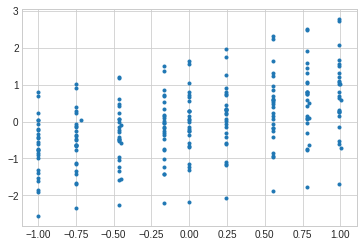

In [4]:
plt.scatter(data.age, data.height_s, marker='.')

In [5]:
with pm.Model() as m1:
    a = pm.Normal('a', mu=0, sd=3)
    b_age = pm.Normal('b_age', mu=0, sd=1.5)

    h = pm.Deterministic('h', a + b_age * data.age)
    
    sigma = pm.HalfCauchy('sigma', beta=5)
    obs = pm.Normal('obs', mu=h, sd=sigma,
                    observed=data.height_s)

    m1.name = 'linear regression'
    m1.trace = pm.sample(2000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_age, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1722.19draws/s]


/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


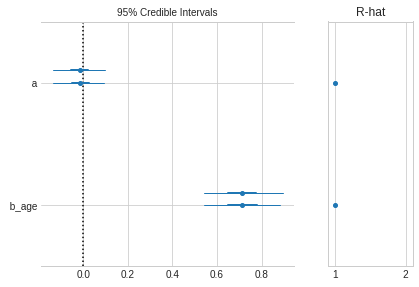

In [6]:
pm.forestplot(m1.trace, varnames=['a', 'b_age'])
None

In [7]:
with pm.Model() as m2:
    a = pm.Normal('a', mu=0, sd=2)

    K_subj = pm.LKJCholeskyCov(
        'K_subj', n=2, eta=1,
        sd_dist=pm.Exponential.dist(lam=1, shape=2)
    )
    chol = pm.expand_packed_triangular(2, K_subj)
 
    subj = pm.MvNormal(
        'subj', mu=[0, 0], chol=chol,
        shape=(n_subjects, 2)
    )

    subj_a = pm.Deterministic('subj_a', subj[:, 0])
    subj_age = pm.Deterministic('subj_age', subj[:, 1])

    h = pm.Deterministic(
        'h',
        subj_a[(data.Subject.values - 1)]
        + subj_age[(data.Subject.values - 1)] * data.age.values
    )

    sigma = pm.HalfCauchy('sigma', beta=5)
    obs = pm.Normal('obs', mu=h, sd=sigma,
                    observed=data.height_s)

    m2.name = 'covariate subjects'
    m2.trace = pm.sample(2000, tune=2000, chains=2)

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a 

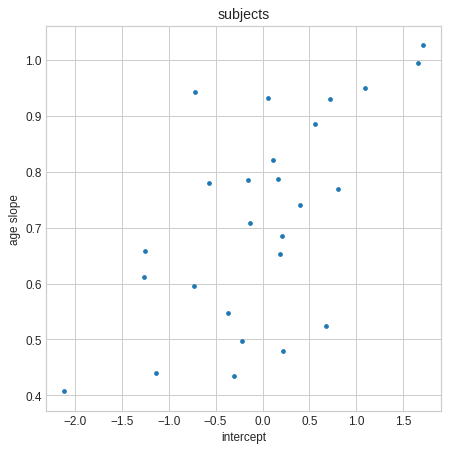

In [10]:
plt.figure(figsize=(6, 6), dpi=85)
plt.scatter(m2.trace['subj_a'].mean(axis=0),
            m2.trace['subj_age'].mean(axis=0),
            marker='.')
plt.gca().set(xlabel='intercept', ylabel='age slope',
              title='subjects')
None

In [ ]:
np.array([
    m2.trace['subj_a'].shape
for _age in (-1, 0, 1):
    
])

    _h = 

(4000, 26)

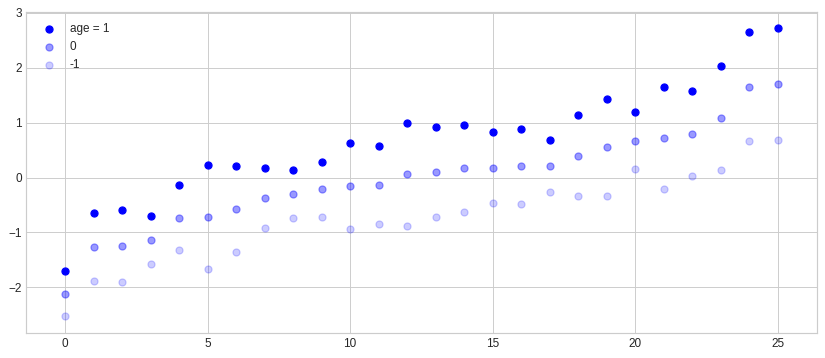

In [35]:
_a = m2.trace['subj_a']
_b = m2.trace['subj_age']

_h = pd.DataFrame(
    {_age: (_a + _b * _age).mean(axis=0)
     for _age in (-1, 0, 1)}
)

_h = _h.sort_values(0).reset_index(drop=True)

plt.figure(figsize=(12, 5), dpi=85)
plt.scatter(_h.index, _h[1],
            color='b', label='age = 1')
plt.scatter(_h.index, _h[0],
            color='b', alpha=.4, label='0')
plt.scatter(_h.index, _h[-1],
            color='b', alpha=.2, label='-1')
plt.legend()
None

In [36]:
pm.compare({
    m1: m1.trace,
    m2: m2.trace,
})

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
covariate subjects,-503.15,49.47,0,1,23.53,0,1
linear regression,612.64,3.17,1115.8,0,22.5,32.7,0
